Loading Women's Data (Simplified Earnings Control)...
decision_maker     Mainly wife  Wife and husband jointly  Mainly husband
Rwamagana                   18                        78               5
Nyagatare                   21                        66              13
Gatsibo                     14                        68              18
Kayonza                     14                        80               5
Kirehe                      24                        64              12
Ngoma                       13                        81               6
Bugesera                    24                        66              10
East Province               18                        72              10
Rwanda (National)           23                        67               9
✅ Success! Categories merged and results saved.


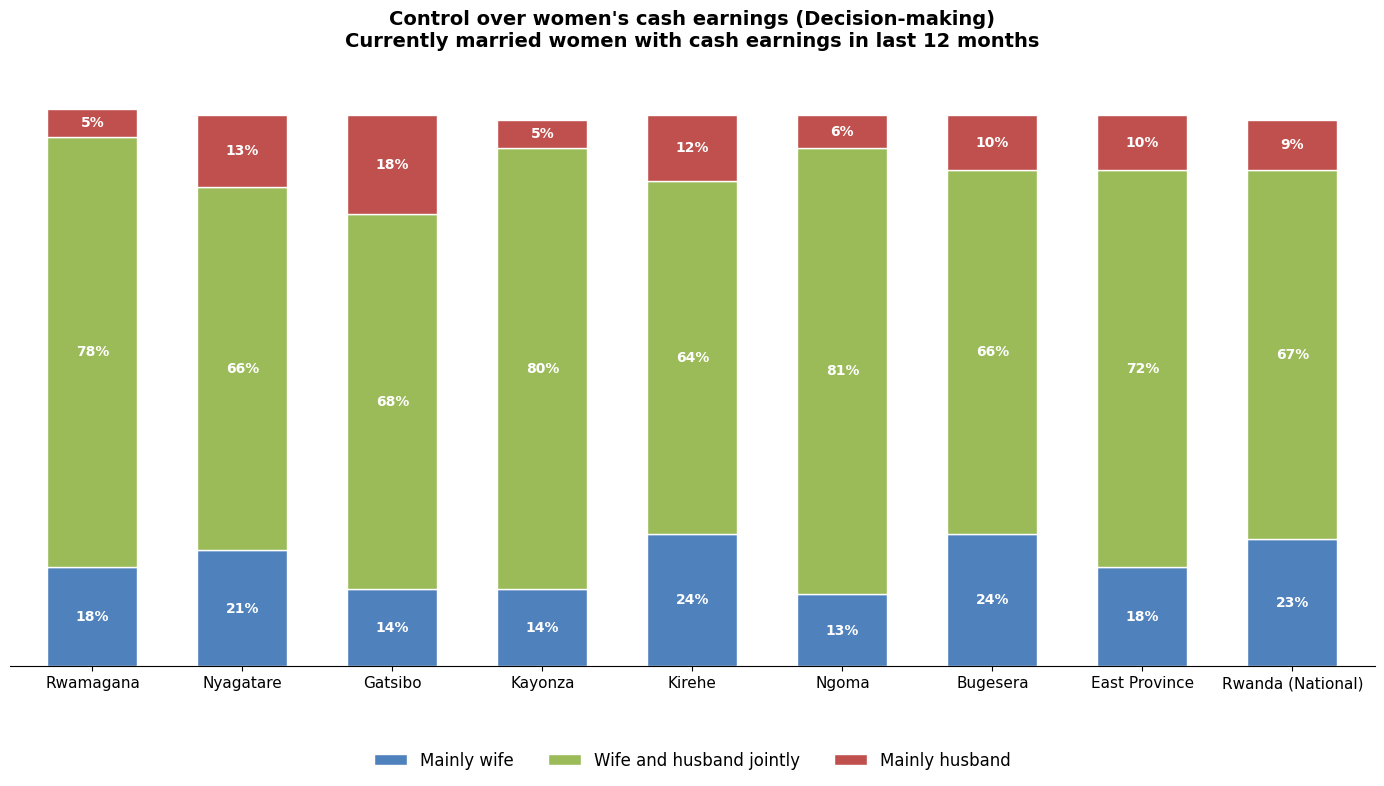

In [2]:
#!/usr/bin/env python3
# dhs_women_earnings_simplified.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# Categories (Merged 'Other' into 'Mainly husband')
PLOT_ORDER = ["Mainly wife", "Wife and husband jointly", "Mainly husband"]
COLORS = ["#4F81BD", "#9BBB59", "#C0504D"]

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    return int(math.floor(n + 0.5))

def get_distribution(df):
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return pd.Series({k: 0 for k in PLOT_ORDER})
    
    counts = df.groupby('decision_maker')['w'].sum()
    total = counts.sum()
    pcts = (counts / total) * 100
    
    return pcts.reindex(PLOT_ORDER, fill_value=0).apply(standard_round)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data (Simplified Earnings Control)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- ACCURACY FILTERS ---
    # 1. Currently Married
    df = df[df['v502'] == 1].copy()

    # 2. Had cash earnings (v739 valid)
    df = df[df['v739'].isin([1, 2, 3, 4, 5, 6])].copy()

    # Weights
    df['w'] = pd.to_numeric(df['v005']) / 1000000.0
    dist_col = next((c for c in ['sdistrict', 'sdstr'] if c in df.columns), 'v001')

    # THE MERGE LOGIC: 
    # Code 1 -> Wife | Code 2 -> Jointly | Everything else (3, 4, 5, 6) -> Husband
    def map_simplified_decision(val):
        if val == 1: return "Mainly wife"
        if val == 2: return "Wife and husband jointly"
        return "Mainly husband"

    df['decision_maker'] = df['v739'].apply(map_simplified_decision)

    # --- AGGREGATION ---
    results = {}
    df_east = df[df['v024'] == 5].copy()
    
    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_distribution(subset)

    results["East Province"] = get_distribution(df_east)
    results["Rwanda (National)"] = get_distribution(df)

    final_df = pd.DataFrame(results).T[PLOT_ORDER]
    print(final_df)

    # JSON
    with open("eastern_women_earnings_simplified.json", "w") as f:
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # PLOT
    ax = final_df.plot(kind="bar", stacked=True, color=COLORS, figsize=(14, 8), width=0.6, edgecolor="white")

    plt.title("Control over women's cash earnings (Decision-making)\nCurrently married women with cash earnings in last 12 months", 
              fontsize=14, fontweight='bold', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    plt.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.12), frameon=False, fontsize=12)

    for c in ax.containers:
        labels = [f"{int(v)}%" if v >= 3 else "" for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold')

    plt.tight_layout()
    plt.savefig("Women_Earnings_Simplified.png", dpi=300)
    print("✅ Success! Categories merged and results saved.")